In [1]:
%%html 
<style>
    code,kbd,pre,samp,.Codemirror{
        font-family: Menlo, Monaco, Consolas, monospace !important
    }
</style>

In [2]:
from itertools import product
from PIL import Image, ImageOps

import numpy as np
import pandas as pd
import tensorflow as tf
sess = tf.InteractiveSession()

import matplotlib
import seaborn as sns
plt = matplotlib.pyplot

%matplotlib inline

sns.set_style('whitegrid')

matplotlib.rcParams.update({'figure.figsize': (10, 6)})
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({'font.family': 'Helvetica, Arial, sans-serif'})

%config InlineBackend.figure_format = 'retina'

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
# Parameters controlling the entire experiment
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

image_size = (32, 32) # Size for all images
flip_images = True    # Double the dataset by mirroring it?
dataset_sample = None # How much of the dataset do we want? (None = don't subsample)

evaluation_function = roc_auc_score

In [4]:
import os.path
import random

def generate_dataset_archive(overwrite=False):
    '''
    load all images data/cat.{i}.jpg and data/dog.{i}.jpg
    for i in 0...12499 inclusive, then downscale to
    image_size and archive as a compressed .npz file.
    
    expects you to have extracted the dogs vs. cats
    dataset from kaggle into a folder underneath this
    notebook called data. it consists of 25000 JPEG images.
    '''    
    archive_name = 'dogs_vs_cats.npz'
    file_prefix = 'data/'
    PIL_GRAYSCALE_MODE = 'L'
    images = []
    labels = []
    images_per_class = 12500
    
    archive_exists = os.path.isfile(archive_name)
    if not overwrite and archive_exists:
        print(f'The archive file {archive_name} already exists.\nSkipping data processing.\n')
        return
    elif overwrite and archive_exists:
        print('Processing data and overwriting to archive file...')
    else:
        print('Processing data and creating new archive file...')
        
    print(f'Loading {images_per_class*2} images and compressing to size {image_size}')
    
    for pet_type, index in product(['cat','dog'], range(images_per_class)):
        file_name = f'{pet_type}.{index}'
        image = Image.open(f'{file_prefix}{file_name}.jpg').convert(mode=PIL_GRAYSCALE_MODE)
        image = ImageOps.fit(image, image_size, method=Image.ANTIALIAS)
        data = np.array(image.getdata())
        
        is_dog = (pet_type == 'dog')
        images.append(data)
        labels.append(is_dog)
    
    # numpy archive (.npz) of multiple objects
    np.savez_compressed(
        archive_name, 
        data=np.array(images,dtype=np.uint8), 
        target=np.array(labels,dtype=np.bool_)
    )
    print('Saved.')
    print()

## numpy method (slow, CPU bound)
# def normalize_scalar(x):
#     return 2*((x/255)-0.5)
# normalize = np.vectorize(normalize_scalar, otypes=[np.float32])
# def normalize(data):
#     print('Mapping int8 data [0,255] to float32 [-1,1]\n')
#     _normalize_scalar=lambda x:2*((x/255)-0.5)
#     _normalize=np.vectorize(_normalize_scalar,otypes=[np.float32])
#     return np.apply_along_axis(_normalize, 0, data)

# tensorflow (11x faster on GPU)
def normalize(data):
    print('Mapping int8 data [0,255] to float32 [-1,1]\n')
    tensor = tf.convert_to_tensor(data, np.float32)
    tensor = tensor/127.5 - 1
    return tensor.eval()

def flip_bitmap(data):
    data = data.reshape(image_size)
    data = np.fliplr(data)
    return data.flatten()
flip_all_images = np.vectorize(flip_bitmap, otypes=[np.float32])
    
def flip_dataset(data,target):
    data_flipped = np.copy(data)
    data_flipped = np.apply_along_axis(flip_bitmap, 1, data_flipped)
    return np.vstack((data,data_flipped)), np.concatenate((target,target))

def load_dataset_archive(sample=None, flip=False):
    '''
    pick a random sample from the total population of images.
    create horizontally mirrored duplicates of all source images
    if requested.
    '''
    archive_name = 'dogs_vs_cats.npz'
    ds = np.load(archive_name)
    
    image_count = ds["data"].shape[0]
    sample_count = image_count
    print(f'Loaded archive with a total of {image_count} images.')
    
    if sample is None:
        print(f'No sampling - using full dataset ({image_count} images)')
        data = ds['data']
        target = ds['target']
    elif 0.0 > sample < 1.0:
        raise ValueError('Sample rate must be between 0 and 1')
    elif sample is not None:
        sample_count = int(sample * image_count)
        if sample_count == 0:
            raise ValueError(f'A sample rate of {sample} yields a zero-sized sample!')
        print(f'Randomly sampling {sample*100}% of the dataset ({sample_count}/{image_count})')
        sample = random.sample(range(image_count), sample_count)
        data = ds['data'][sample]
        target = ds['target'][sample]
        
    if flip: 
        print(f'Flipping to double dataset ({sample_count*2} images)')
        data, target = flip_dataset(data, target)
    print()
    return data, target

In [5]:
# Loading the whole dataset from individual image files
# (25,000 images total) is very slow. This function
# generates a numpy archive (.npz) of the downsized grayscale
# images if it doesn't already exist. This saves time when
# rerunning the notebook.
%time generate_dataset_archive()

The archive file dogs_vs_cats.npz already exists.
Skipping data processing.

CPU times: user 1.16 ms, sys: 890 µs, total: 2.05 ms
Wall time: 1.14 ms


In [6]:
print('LOADING + EXPANSION\n','—'*50,sep='')
%time data_raw, target = load_dataset_archive(sample=dataset_sample, flip=flip_images)

print('\nNORMALIZATION\n','—'*50,sep='')
%time data = normalize(data_raw)

print('\nimages stored as dtype',data.dtype)
print(len(data),'images,',image_size,'pixels each')

mem = data.nbytes
print('RAM usage:',mem/1000000.,'MB')

LOADING + EXPANSION
——————————————————————————————————————————————————
Loaded archive with a total of 25000 images.
No sampling - using full dataset (25000 images)
Flipping to double dataset (50000 images)

CPU times: user 340 ms, sys: 17.6 ms, total: 358 ms
Wall time: 355 ms

NORMALIZATION
——————————————————————————————————————————————————
Mapping int8 data [0,255] to float32 [-1,1]

CPU times: user 877 ms, sys: 689 ms, total: 1.57 s
Wall time: 1.49 s

images stored as dtype float32
50000 images, (32, 32) pixels each
RAM usage: 204.8 MB


In [7]:
# [CITE] "04. Dimension Reduction and Images Notebook" by Eric Larson

def plot_gallery(imgs, titles, size, rows=3, cols=6):
    plt.figure(figsize = (1.7 * cols, 2.3 * rows))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    
    for i in range(rows * cols):
        plt.subplot(rows, cols, i+1)
        ax = plt.gca()
        [spine.set_color('black') for _,spine in ax.spines.items()]
        plt.imshow(imgs[i].reshape(size), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks([]); plt.yticks([])
    plt.show()

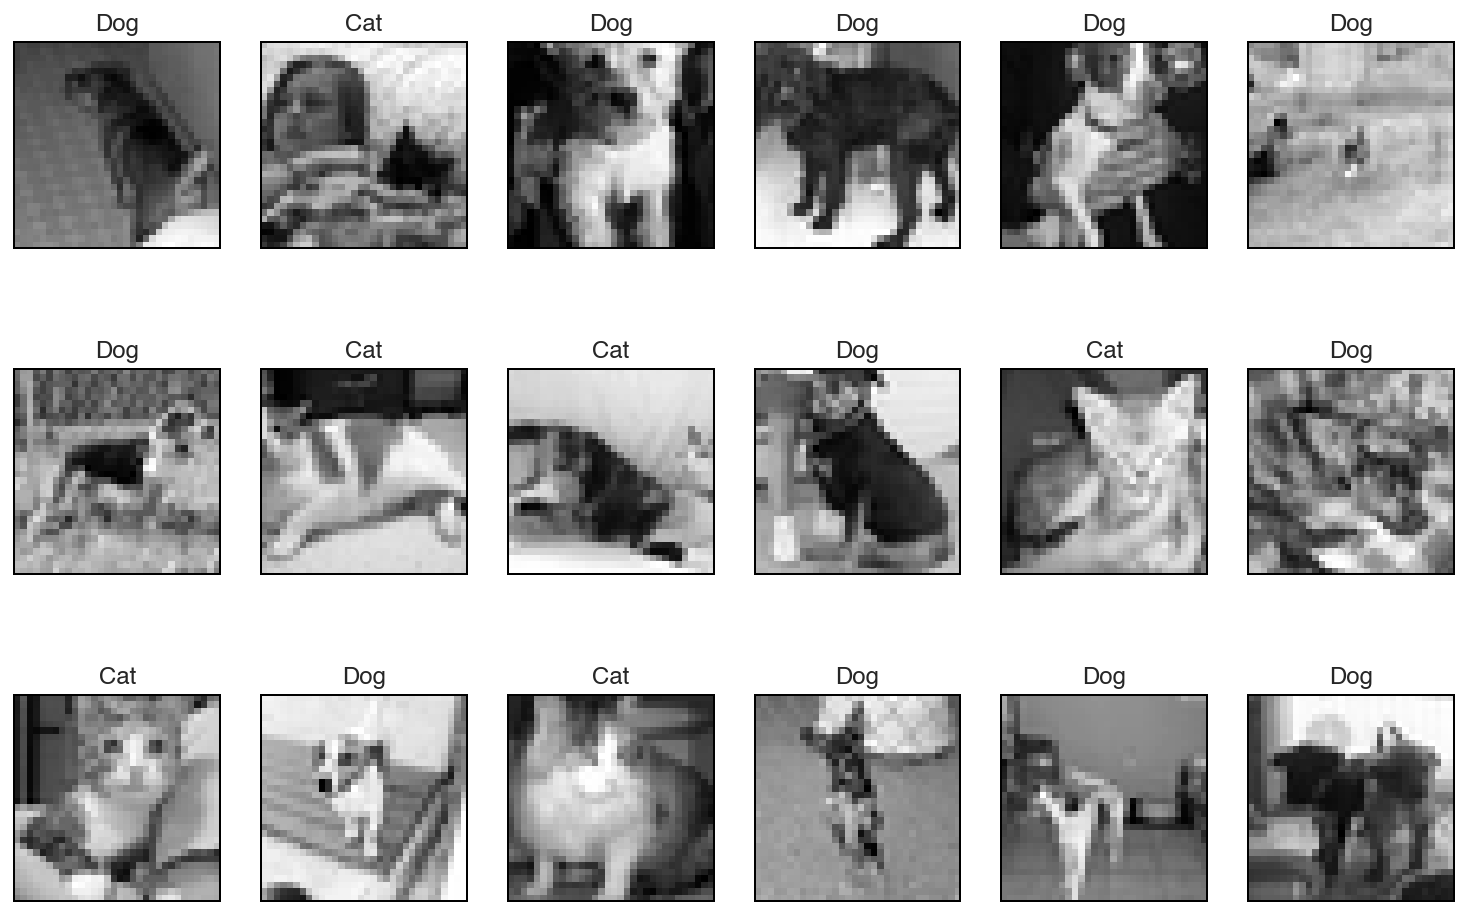

In [8]:
idx = np.random.choice(data_raw.shape[0], 18, replace=False)
some_images = data_raw[idx]
some_labels = np.vectorize(lambda x: 'Dog' if x else 'Cat')(target[idx])
plot_gallery(some_images, some_labels, image_size)

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Reshape, Dense, BatchNormalization,\
Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from keras.callbacks import Callback
from tqdm import tqdm

try:
    from IPython.core.display import clear_output
    is_ipython = True
except ImportError:
    clear_output = lambda *args: None
    is_ipython = False

class ConvolutionalNeuralNet:
    def __init__(
        self,
        input_shape,
        n_filters,
        dense_sizes,
        output_size,
        
        batch_normalize = True,

        layer_activation='relu',
        final_activation='softmax',

        loss='mean_squared_error', 
        optimizer='rmsprop', 
        metrics=['binary_accuracy'],

        batch_size=32,
        epochs=50,
        shuffle=False,
        verbose=2,
        epoch_callback=None
    ):
        self.input_shape = input_shape
        self.n_filters = n_filters
        self.dense_sizes = dense_sizes
        self.output_size = output_size
        
        self.batch_normalize = batch_normalize
        
        self.layer_activation = layer_activation
        self.final_activation = final_activation
        
        self.loss = loss
        self.optimizer = optimizer
        self.metrics = metrics
        
        self.batch_size = batch_size
        self.epochs = epochs
        self.shuffle = shuffle
        self.verbose = verbose
        
        self.epoch_callback = epoch_callback
        
        self._make_model()
    
    def _make_convolution_layers(self):
        self._model.add(
            Reshape(
                (1, self.input_shape[0], self.input_shape[1]), 
                input_shape=(1, self.input_shape[0]*self.input_shape[1])
            )
        )
                       
        for filters in self.n_filters:
            # Add a single convolution layer
            self._model.add(
                Conv2D(
                    filters=filters,
                    kernel_size=(3,3),
                    padding='same',
                    activation=self.layer_activation
                )
            )
            # Add batch normalization to the convolution layer
            if self.batch_normalize:
                self._model.add(
                    BatchNormalization(axis=1)
                )
            # Pool the layer
            self._model.add(
                MaxPooling2D(pool_size=(2,2), data_format='channels_first')
            )
        
        self._model.add(Flatten())
                
    def _make_dense_layers(self):
        for size in self.dense_sizes:
            self._model.add(
                Dense(size, activation=self.layer_activation)
            )
            if self.batch_normalize:
                self._model.add(
                    BatchNormalization(axis=1)
                )
        self._model.add(
            Dense(self.output_size, activation=self.final_activation)
        )
                
    def _make_model(self):
        self._model = Sequential()
        
        self._make_convolution_layers()
        self._make_dense_layers()
        
        self._model.compile(
            loss=self.loss,
            optimizer=self.optimizer,
            metrics=self.metrics
        )
                
    def fit(self, X_raw, y):
        # Using keras Callbacks to hook into end of epoch
        # for per-epoch evaluation statistics collection
        # [CITE] https://github.com/fchollet/keras/issues/2548#issuecomment-215664770
        self.epoch_log_ = []
        net = self
        progress_bar = None
        if self.verbose == 3:
            progress_bar = tqdm(total=self.epochs)
        
        class AnalyticsCallback(Callback):
            def on_epoch_end(self, epoch, logs={}):
                net.epoch_log_.append(logs)
                if net.verbose == 3:
                    clear_output()
                    progress_bar.update(1)
                if net.epoch_callback is not None:
                    net.epoch_callback(epoch)
        
        X = np.matrix(X_raw.tolist())
        X = np.expand_dims(X, axis=1)
        self._model.fit(
            X, y, 
           batch_size=self.batch_size,
           epochs=self.epochs,
           shuffle=self.shuffle,
           verbose=self.verbose if self.verbose != 3 else 0,
           callbacks=[AnalyticsCallback()]
        )
        if self.verbose == 3:
            progress_bar.close()
                       
    def predict(self, X_raw):
        X = np.matrix(X_raw.tolist())
        X = np.expand_dims(X, axis=1)
        return self._model.predict(X)
    
    @staticmethod
    def one_hot_output(y_hat_raw):
        # predict() outputs floats. We want one-hot in most cases
        y_hat = np.zeros(y_hat_raw.shape, dtype=np.int)
        y_hat[np.arange(y_hat_raw.shape[0]), y_hat_raw.argmax(1)] = 1
        return y_hat

Using TensorFlow backend.


In [10]:
# we store the networks in this array
# so we can grab their epoch_log_ properties
# wherein we persist the per-epoch accuracy
# so we can make pretty charts.

from tqdm import tqdm

try:
    from IPython.core.display import clear_output
except ImportError:
    pass
    
class CrossValidation:
    def __init__(self, cv, verbose=False):
        self.cv = cv
        self.verbose = verbose
        self.progress = None

    def run(self, ModelClass, parameters):
        cv_indices = self.cv.split(data, target)
        scores = np.empty(n_splits)
        nets = [None]*n_splits

        if 'epochs' in parameters:
            total_epochs = n_splits*parameters['epochs']
#             print(
#                 f'Performing {n_splits}-fold Stratified CV\nat {parameters["epochs"]} '
#                 f'epochs each ({total_epochs} epochs total)'
#             )
        if self.verbose:
            self.progress = tqdm(range(total_epochs),ncols=70,unit='epoch')
        for i,indices in enumerate(cv_indices):
            scores[i],nets[i] = self._step(ModelClass, indices, parameters)

        return scores,nets
    
    def _step(self, ModelClass, indices, parameters): 
        train_index, test_index = indices
        X_train = data[train_index]
        y_train = np.asarray(pd.get_dummies(target[train_index]))
        X_test = data[test_index]
        y_test = target[test_index]
    
        up = self._update_progress
        def make_epoch_handle():
            def epoch_handle(epoch):
                up()
            return epoch_handle

        if 'epoch_callback' in parameters and self.progress is not None:
            parameters['epoch_callback'] = make_epoch_handle()

        # training
        clf = ModelClass(**parameters)
        clf.fit(X_train, y_train)

        # testing
        y_hat_raw = clf.predict(X_test)
        y_hat = ModelClass.one_hot_output(y_hat_raw)
        score = evaluation_function(pd.get_dummies(y_test), y_hat)
        return score,clf
    
    def _clear(self):
        try:
            clear_output(wait=True)
        except AttributeError:
            pass
    
    def _update_progress(self):
        self._clear()
        self.progress.update(1)
    
    @staticmethod
    def get_logs_from_nets(nets, parameter_name):
        return [[epoch[parameter_name] for epoch in net.epoch_log_] for net in nets]

In [11]:
params = dict(
    input_shape=image_size,

    n_filters=[32,64,64,256,256],
    dense_sizes=[128,128],

    output_size=2,

    loss='binary_crossentropy', 
    optimizer='Nadam', 
    metrics=['binary_accuracy'],

    batch_size=32,
    epochs=40,
    shuffle=True,
    verbose=0,
    epoch_callback=None # do not remove
)

In [13]:
n_splits = 5
skfold = StratifiedKFold(n_splits=n_splits, random_state=None, shuffle=False)
cv = CrossValidation(skfold, verbose=True)

In [14]:
import os.path
archive_name = 'cv_result.npz'
archive_exists = os.path.isfile(archive_name)

if not archive_exists:
    print('Results could not be loaded. Performing CV from scratch.')
    scores, nets = cv.run(ConvolutionalNeuralNet, params)
    accs = get_logs_from_nets(nets, 'binary_accuracy')
    np.savez(archive_name, scores=scores, accs=accs)
else:
    print('Archived results found on disk. Reloading.')
    print(f'(to perform CV from scratch, delete {archive_name})')
    ds = np.load(archive_name)
    scores, accs = ds['scores'], ds['accs']


 58%|████████████████▍           | 117/200 [19:44<13:54, 10.06s/epoch]

KeyboardInterrupt: 

In [ ]:
ax = plt.bar(range(len(scores)),scores)
plt.xticks(range(n_splits),range(1,n_splits+1))
plt.title(f'Stratified {n_splits}-fold cross validation')
plt.xlabel('Fold #')
plt.ylabel('Score')

print(
    '\n','='*50,'Accuracy (ROC): %0.2f (±%0.2f)' % (np.asarray(scores).mean(), np.asarray(scores).std() * 2),
    '='*50,'\n',sep='\n'
)

In [ ]:
# https://gist.github.com/phrz/98045738d182dd75d1eed74470b9b2ef

def average_line(data, plot_quartiles=True, color='#016d91'):
    '''
    Given 2D data where columns are samples and rows are classes/time series, 
    plot an average line and surrounding quartile area 
    (like a continuous box plot)
    '''
    averages = np.average(data,axis=0)
    x = np.arange(1, len(averages)+1)
    plt.plot(x, averages, color=color)

    if plot_quartiles:
        lower = np.percentile(accs, 25, axis=0)
        upper = np.percentile(accs, 75, axis=0)
        plt.fill_between(x, lower, upper, color=color, alpha='0.25', linewidth=0)

In [ ]:
average_line(accs)
plt.xlabel('epoch')
plt.ylabel('score')
plt.title('Binary accuracy by epoch (all folds)');

In [ ]:
sess.close()